# *Chapter 3 - Classification using MNIST*

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
print(type(mnist))

<class 'sklearn.utils.Bunch'>


In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X,y=mnist["data"],mnist["target"]
'''
X = collection of image data in a vectorized form. (28x28=784)
y = actual numerical value corresponding to the image (i.e. 0,1,2,..,9)
'''
print("X.shape =",X.shape)
print("y.shape =",y.shape)

X.shape = (70000, 784)
y.shape = (70000,)


some_digit.shape = (784,)
some_digit_image.shape = (28, 28)


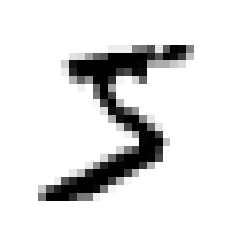

In [4]:
# Reshape data[0] and display the digit image from a row to 28x28
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=X[0]
print("some_digit.shape =",some_digit.shape)
some_digit_image=some_digit.reshape(28,28)
print("some_digit_image.shape =",some_digit_image.shape)

plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
#Check target
y[0]

'5'

In [6]:
# Cast the label in strig to integers
import numpy as np
y=y.astype(np.uint8)

In [7]:
# Split MNIST dataset into a training set and a test set
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## *Training a binary classifier*

In [8]:
# Prepare T/F lists
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5  = (y_test == 5)
print('y_train_5 = ',y_train_5)
print('y_test_5  = ',y_test_5)

y_train_5 =  [ True False False ...  True False False]
y_test_5 =  [False False False ... False  True False]


In [9]:
# Train Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# Test the SGD classifier
sgd_clf.predict([some_digit])

array([ True])

## *Performance measures*

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The scores are too high. Is this classifier that good? Let's test by creating a classifer that never predict 5 as True.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifer(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [13]:
never_5_clf = Never5Classifer()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Still the same high score! This is becuase only 10% of the data is actually 5. There is a better way to evaluate the score.

## *Confusion matrix*

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print('y_train_pred =',y_train_pred)

NameError: name 'sgd_clf' is not defined

In [15]:
from sklearn.metrics import confusion_matrix
print('confusion_matrix = ',confusion_matrix(y_train_5,y_train_pred))

''' # confusion_matrix:
True Negative, False Positive
False Negative, True Positive
'''

print('\nPretend we reached perfection:')
y_train_perfect_pred = y_train_5    # <- setting input and prediction are the same
confusion_matrix(y_train_5,y_train_perfect_pred)

confusion_matrix =  [[53892   687]
 [ 1891  3530]]

Pretend we reached perfection:


array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [16]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score

print('precision_score =',precision_score(y_train_5,y_train_pred))  # = TP/(TP+FP)

# Recall (=sensitivity or true positive rate)
print('recall_score =',recall_score(y_train_5,y_train_pred))  # = TP/(TP+FN)

precision_score = 0.8370879772350012
recall_score =0.6511713705958311


In [17]:
# F1 score (=2*recall*precision/(recall+precision))
from sklearn.metrics import f1_score
print('f1_score =',f1_score(y_train_5,y_train_pred))

f1_score = 0.7325171197343846


F1 requires both precision and recall to be balanced. If one is poor, F1 will also be.

### *Precision/recall tradeoff*

In [36]:
#print('some_digit =',some_digit) <- Recall some_digit is the vectorized version of a single image data of MNIST
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

So, decision_function gives a score for an input data (=some_digit), but the value is some numerical value. We can decide the criterion by the threshold value, but what number to pick?

In [40]:
# Get scores of all instances
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [42]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

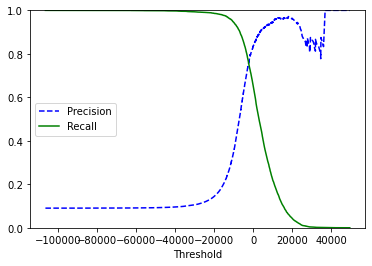

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label ="Precision") 
    plt.plot(thresholds,recalls[:-1],"g-",label ="Recall") 
    plt.xlabel("Threshold") 
    plt.legend(loc ="center left") 
    plt.ylim([0,1])
    #plt.xlim([-60000,60000])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds) 
plt.show()

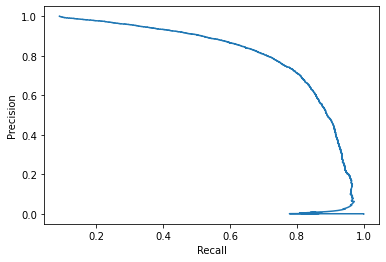

In [50]:
plt.plot(precisions[:-1],recalls[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Receiver operating characteristic (ROC)  

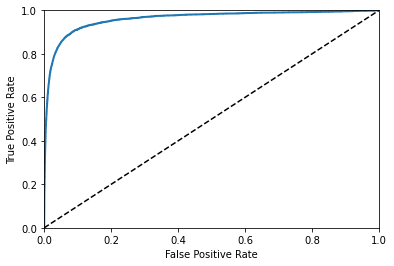

In [51]:
# ROC curve = recall vs. False positive rate
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_5, y_scores)  #<- Area under the curve (AUC)

0.9604938554008616

In [63]:
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

print('thresholds_forest = ',thresholds_forest)

thresholds_forest =  [2.   1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88
 0.87 0.86 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75 0.74
 0.73 0.72 0.71 0.7  0.69 0.67 0.66 0.65 0.64 0.63 0.62 0.61 0.6  0.59
 0.58 0.57 0.56 0.55 0.54 0.53 0.52 0.51 0.5  0.49 0.48 0.47 0.46 0.45
 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36 0.35 0.34 0.33 0.32 0.31
 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21 0.2  0.19 0.18 0.17
 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03
 0.02 0.01 0.  ]


In [ ]:
plt.plot( fpr, tpr, "b:", label ="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend( loc ="lower right") 
plt.show()

In [60]:
roc_auc_score(y_train_5,y_scores_forest)


0.9983436731328145

In [67]:
# To get precision and recall scores, do something similar to ???
#y_train_pred_forest = (y_scores_forest > thresholds_forest)
#precision_score(y_train_5,y_train_pred_forest)

## *Multiclass classification*

In [69]:
# Let's use SDG classifier to predict digits between 0 and 9.
# In the following, notice that y_train is used and not y_train_5

sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

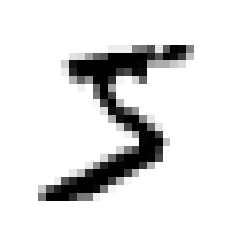

In [76]:
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [77]:
y[0]

5

In [78]:
# To check how this works, call decision_function and check the one with the highest score. 
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [79]:
np.argmax(some_digit_scores)

3

In [81]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [82]:
sgd_clf.classes_[3]

3

In [84]:
# If want to force one-versus-one or one-versus-all, use sklearn's native classifier 
from sklearn.multiclass import OneVsOneClassifier 
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train) 
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [85]:
len(ovo_clf.estimators_)

45

In [86]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [87]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [88]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring ="accuracy")

array([0.8983, 0.891 , 0.9018])

### *Error analysis*

In [92]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3) 
conf_mx = confusion_matrix( y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

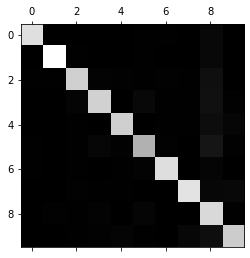

In [93]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

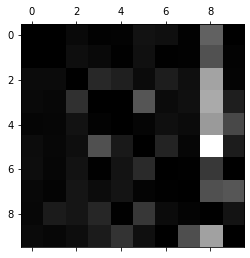

In [94]:
# Compute the error rates (score normalized by the number of errors)
row_sums = conf_mx.sum(axis = 1, keepdims = True) 
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)   # <- Set the diagonals to zeros to focus only on the errors
plt.matshow( norm_conf_mx, cmap = plt.cm.gray) 
plt.show()

In [96]:
cl_a, cl_b = 3, 5 
X_aa = X_train[( y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[( y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[( y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[( y_train == cl_b) & (y_train_pred == cl_b)] 

plt.figure(figsize =(8,8)) 
plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5) 
plt.show()

NameError: name 'plot_digits' is not defined

## *Multilabel classification*

In [8]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
knn_clf.predict([some_digit])  # Here some_digit is the digital info of image "5"

array([[False,  True]])

In [13]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3) 
f1_score(y_multilabel, y_train_knn_pred, average ="macro")

## *Multioutput Classification*

In [ ]:
noise = np.random.randint(0, 100, (len(X_train),784)) 
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test),784)) 
X_test_mod = X_test + noise y_train_mod = X_train y_test_mod = X_test

In [ ]:
some_digit=X_train_mod[0]
print("some_digit.shape =",some_digit.shape)
some_digit_image=some_digit.reshape(28,28)
print("some_digit_image.shape =",some_digit_image.shape)

plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod) 
clean_digit = knn_clf.predict([X_test_mod[some_index]]) 
plot_digit(clean_digit)